In [1]:
from torch import nn
import torch

In [2]:
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

In [4]:
class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None,
                 *, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, 1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.se = SELayer(planes, reduction)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [5]:
class SEBottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None,
                 *, reduction=16):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se = SELayer(planes * 4, reduction)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = self.se(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [6]:
class CifarSEBasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, reduction=16):
        super(CifarSEBasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.se = SELayer(planes, reduction)
        if inplanes != planes:
            self.downsample = nn.Sequential(nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
                                            nn.BatchNorm2d(planes))
        else:
            self.downsample = lambda x: x
        self.stride = stride

    def forward(self, x):
        residual = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        out += residual
        out = self.relu(out)

        return out

In [7]:
class CifarSEResNet(nn.Module):
    def __init__(self, block, n_size, num_classes=10, reduction=16):
        super(CifarSEResNet, self).__init__()
        self.inplane = 16
        self.conv1 = nn.Conv2d(
            3, self.inplane, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplane)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(
            block, 16, blocks=n_size, stride=1, reduction=reduction)
        self.layer2 = self._make_layer(
            block, 32, blocks=n_size, stride=2, reduction=reduction)
        self.layer3 = self._make_layer(
            block, 64, blocks=n_size, stride=2, reduction=reduction)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)
        self.initialize()

    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride, reduction):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inplane, planes, stride, reduction))
            self.inplane = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CifarSEResNet(CifarSEBasicBlock, 3).to(device=device)

In [9]:
x = torch.randn(5, 3, 32, 32)
x = x.to(device=device)
y = model(x)
print(y.shape)
print(y)

torch.Size([5, 10])
tensor([[ 0.0739, -0.1849,  0.2489, -0.2744,  0.0753,  0.0041,  0.3722, -0.2956,
          0.1997, -0.2121],
        [ 0.0845, -0.2174,  0.2501, -0.2467,  0.0936,  0.0482,  0.3763, -0.1558,
          0.1335, -0.1539],
        [ 0.0203, -0.2308,  0.3212, -0.2748,  0.0587,  0.0339,  0.4756, -0.3657,
          0.2349, -0.1304],
        [-0.0031, -0.2441,  0.3429, -0.3569,  0.0713, -0.0511,  0.4820, -0.2344,
          0.0480, -0.1468],
        [-0.0017, -0.2068,  0.2708, -0.3665,  0.0141,  0.0330,  0.4465, -0.3865,
          0.2172, -0.2423]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [10]:
import torchvision.datasets as datasets
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch import optim
from tqdm import tqdm

In [11]:
# Hyperparameters
in_channels = 3
num_classes = 10
learning_rate = 3e-4 # karpathy's constant
batch_size = 64
num_epochs = 50

In [12]:
train_dataset = datasets.CIFAR10(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.CIFAR10(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [15]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

cat


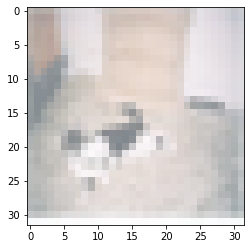

In [16]:
print(classes[labels[63]])
imshow(torchvision.utils.make_grid(images[63]))

In [17]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
# Train Network
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
        
    print('Epoch:', epoch, 'Loss:', loss.item())

  0%|▎                                                                                 | 3/782 [00:00<00:36, 21.27it/s]

Epoch: 0 Loss: 1.4407799243927002


  0%|▎                                                                                 | 3/782 [00:00<00:32, 24.19it/s]

Epoch: 1 Loss: 1.0247036218643188


  0%|▎                                                                                 | 3/782 [00:00<00:35, 21.89it/s]

Epoch: 2 Loss: 1.5052999258041382


  0%|▎                                                                                 | 3/782 [00:00<00:32, 23.99it/s]

Epoch: 3 Loss: 0.8306131958961487


  0%|▏                                                                                 | 2/782 [00:00<00:39, 19.60it/s]

Epoch: 4 Loss: 1.207198143005371


  0%|▎                                                                                 | 3/782 [00:00<00:39, 19.60it/s]

Epoch: 5 Loss: 0.5214865207672119


  0%|▎                                                                                 | 3/782 [00:00<00:37, 20.69it/s]

Epoch: 6 Loss: 0.4099693298339844


  0%|▏                                                                                 | 2/782 [00:00<00:48, 16.00it/s]

Epoch: 7 Loss: 0.6468737721443176


  0%|▏                                                                                 | 2/782 [00:00<00:39, 20.00it/s]

Epoch: 8 Loss: 0.7168174982070923


  0%|▎                                                                                 | 3/782 [00:00<00:38, 20.00it/s]

Epoch: 9 Loss: 0.6899118423461914


  0%|▎                                                                                 | 3/782 [00:00<00:38, 20.40it/s]

Epoch: 10 Loss: 0.2932896316051483


  0%|▎                                                                                 | 3/782 [00:00<00:37, 20.97it/s]

Epoch: 11 Loss: 1.078244686126709


  0%|▎                                                                                 | 3/782 [00:00<00:30, 25.86it/s]

Epoch: 12 Loss: 0.7707359790802002


  0%|▏                                                                                 | 2/782 [00:00<00:39, 20.00it/s]

Epoch: 13 Loss: 0.3647458553314209


  0%|▎                                                                                 | 3/782 [00:00<00:29, 26.78it/s]

Epoch: 14 Loss: 0.23099486529827118


  0%|▎                                                                                 | 3/782 [00:00<00:31, 24.79it/s]

Epoch: 15 Loss: 0.4691210687160492


  0%|▎                                                                                 | 3/782 [00:00<00:42, 18.51it/s]

Epoch: 16 Loss: 0.7977509498596191


  0%|▎                                                                                 | 3/782 [00:00<00:38, 20.13it/s]

Epoch: 17 Loss: 0.012034214101731777


  0%|▎                                                                                 | 3/782 [00:00<00:36, 21.58it/s]

Epoch: 18 Loss: 0.17380814254283905


  0%|▎                                                                                 | 3/782 [00:00<00:29, 26.54it/s]

Epoch: 19 Loss: 0.6242260336875916


  0%|▎                                                                                 | 3/782 [00:00<00:44, 17.34it/s]

Epoch: 20 Loss: 0.42118287086486816


  0%|▏                                                                                 | 2/782 [00:00<00:39, 19.60it/s]

Epoch: 21 Loss: 0.0848858579993248


  0%|▎                                                                                 | 3/782 [00:00<00:39, 19.73it/s]

Epoch: 22 Loss: 0.009353876113891602


  0%|▎                                                                                 | 3/782 [00:00<00:30, 25.86it/s]

Epoch: 23 Loss: 0.5300139784812927


  0%|▎                                                                                 | 3/782 [00:00<00:33, 23.07it/s]

Epoch: 24 Loss: 0.4393587112426758


  0%|▏                                                                                 | 2/782 [00:00<00:40, 19.23it/s]

Epoch: 25 Loss: 0.03454442322254181


  0%|▎                                                                                 | 3/782 [00:00<00:30, 25.20it/s]

Epoch: 26 Loss: 0.8073416352272034


  0%|▎                                                                                 | 3/782 [00:00<00:29, 26.31it/s]

Epoch: 27 Loss: 0.11131254583597183


  0%|▎                                                                                 | 3/782 [00:00<00:42, 18.51it/s]

Epoch: 28 Loss: 0.38377928733825684


  0%|▎                                                                                 | 3/782 [00:00<00:27, 28.57it/s]

Epoch: 29 Loss: 0.051212310791015625


  0%|▎                                                                                 | 3/782 [00:00<00:30, 25.42it/s]

Epoch: 30 Loss: 0.32010167837142944


  0%|▎                                                                                 | 3/782 [00:00<00:30, 25.20it/s]

Epoch: 31 Loss: 0.12759529054164886


  0%|▎                                                                                 | 3/782 [00:00<00:40, 19.35it/s]

Epoch: 32 Loss: 0.1757853478193283


  0%|▎                                                                                 | 3/782 [00:00<00:37, 20.97it/s]

Epoch: 33 Loss: 0.006228551734238863


  0%|▎                                                                                 | 3/782 [00:00<00:31, 24.79it/s]

Epoch: 34 Loss: 0.21695049107074738


  0%|▎                                                                                 | 3/782 [00:00<00:38, 20.00it/s]

Epoch: 35 Loss: 0.23471814393997192


  0%|▎                                                                                 | 3/782 [00:00<00:30, 25.86it/s]

Epoch: 36 Loss: 0.011527365073561668


  0%|▎                                                                                 | 3/782 [00:00<00:30, 25.63it/s]

Epoch: 37 Loss: 0.02822583168745041


  0%|▎                                                                                 | 3/782 [00:00<00:30, 25.86it/s]

Epoch: 38 Loss: 0.03294726088643074


  0%|▎                                                                                 | 3/782 [00:00<00:34, 22.55it/s]

Epoch: 39 Loss: 0.640845775604248


  0%|▏                                                                                 | 2/782 [00:00<00:39, 20.00it/s]

Epoch: 40 Loss: 0.011554703116416931


  0%|▏                                                                                 | 2/782 [00:00<00:46, 16.95it/s]

Epoch: 41 Loss: 0.013470777310431004


  0%|▎                                                                                 | 3/782 [00:00<00:38, 20.13it/s]

Epoch: 42 Loss: 0.016682371497154236


  0%|▏                                                                                 | 2/782 [00:00<00:39, 19.60it/s]

Epoch: 43 Loss: 0.03726208209991455


  0%|▎                                                                                 | 3/782 [00:00<00:29, 26.54it/s]

Epoch: 44 Loss: 0.0866178646683693


  0%|▎                                                                                 | 3/782 [00:00<00:32, 23.97it/s]

Epoch: 45 Loss: 0.1735491305589676


  0%|▎                                                                                 | 3/782 [00:00<00:30, 25.20it/s]

Epoch: 46 Loss: 0.01933961547911167


  0%|▎                                                                                 | 3/782 [00:00<00:32, 23.99it/s]

Epoch: 47 Loss: 0.014242498204112053


  0%|▎                                                                                 | 3/782 [00:00<00:28, 27.77it/s]

Epoch: 48 Loss: 0.08994904905557632


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [00:39<00:00, 19.97it/s]

Epoch: 49 Loss: 0.14275231957435608


In [19]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

index number: 0


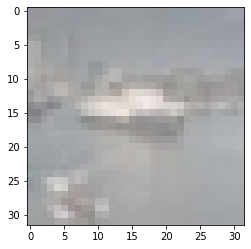

true label: ship
predict label: ship
index number: 1


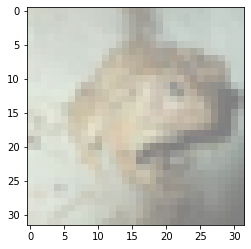

true label: frog
predict label: frog
index number: 2


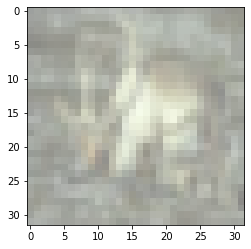

true label: deer
predict label: cat
index number: 3


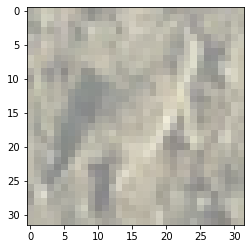

true label: frog
predict label: frog
index number: 4


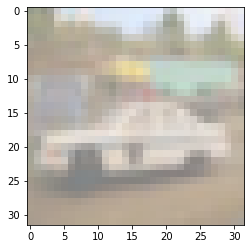

true label: car
predict label: car
index number: 5


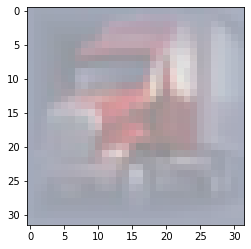

true label: truck
predict label: horse
index number: 6


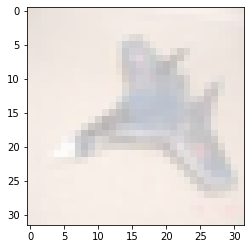

true label: plane
predict label: plane
index number: 7


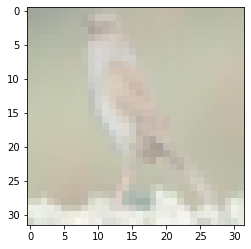

true label: bird
predict label: bird
index number: 8


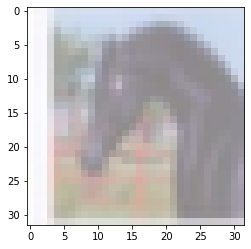

true label: horse
predict label: dog
index number: 9


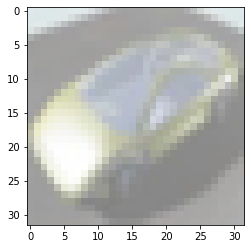

true label: car
predict label: car
index number: 10


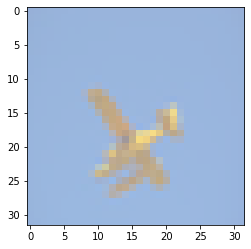

true label: plane
predict label: bird
index number:  


In [20]:
while True:
    i = input("index number: ")
    if i == ' ':
        break
    i = int(i)
    imshow(torchvision.utils.make_grid(images[i]))
    print('true label:',classes[labels[i]])
    prediction = model(images.to(device=device))
    max_index = np.argmax(prediction[i,:].cpu().detach().numpy())
    print('predict label:',classes[max_index])